In [1]:
import os
import numpy as np
import cv2
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
import seaborn as sns
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Conv2D, MaxPool2D, Flatten, Dropout, Dense
from tensorflow.keras.optimizers import Adam

In [2]:
data_path = r'C:\Users\anagh\Downloads\DD'
wave_train_path = os.path.join(data_path, 'wave', 'wave', 'training')

In [3]:
def load_images_from_directory(directory, img_size=(128, 128)):
    images = []
    labels = []
    for label in os.listdir(directory):
        label_dir = os.path.join(directory, label)
        if os.path.isdir(label_dir):
            for file in os.listdir(label_dir):
                file_path = os.path.join(label_dir, file)
                if file_path.endswith('.png') or file_path.endswith('.jpg'):
                    image = cv2.imread(file_path)
                    image = cv2.resize(image, img_size)  # Resize image to img_size
                    images.append(image)
                    labels.append(label)
    return np.array(images), np.array(labels)

In [4]:
x_train, y_train = load_images_from_directory(wave_train_path)

print(f"x_train shape: {x_train.shape}")
print(f"y_train shape: {y_train.shape}")


x_train shape: (72, 128, 128, 3)
y_train shape: (72,)


In [5]:
# Splitting the data into train and test sets
x_train, x_test, y_train, y_test = train_test_split(x_train, y_train, test_size=0.2, stratify=y_train, random_state=42)



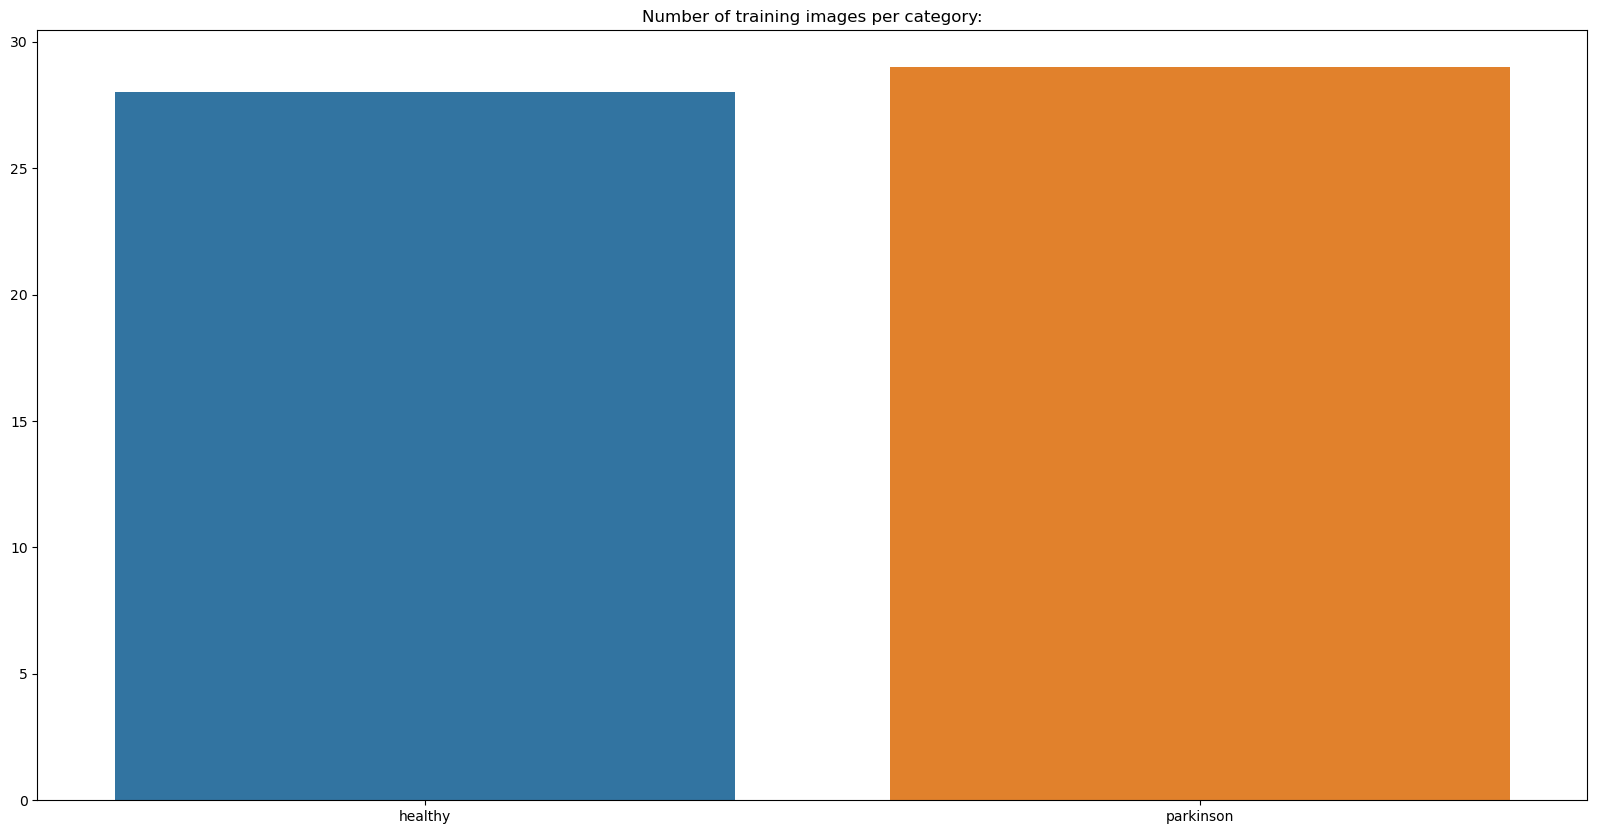

In [6]:
# Data Distribution
unique_train, count_train = np.unique(y_train, return_counts=True)
plt.figure(figsize=(20, 10))
sns.barplot(x=unique_train, y=count_train).set_title("Number of training images per category:")
plt.show()

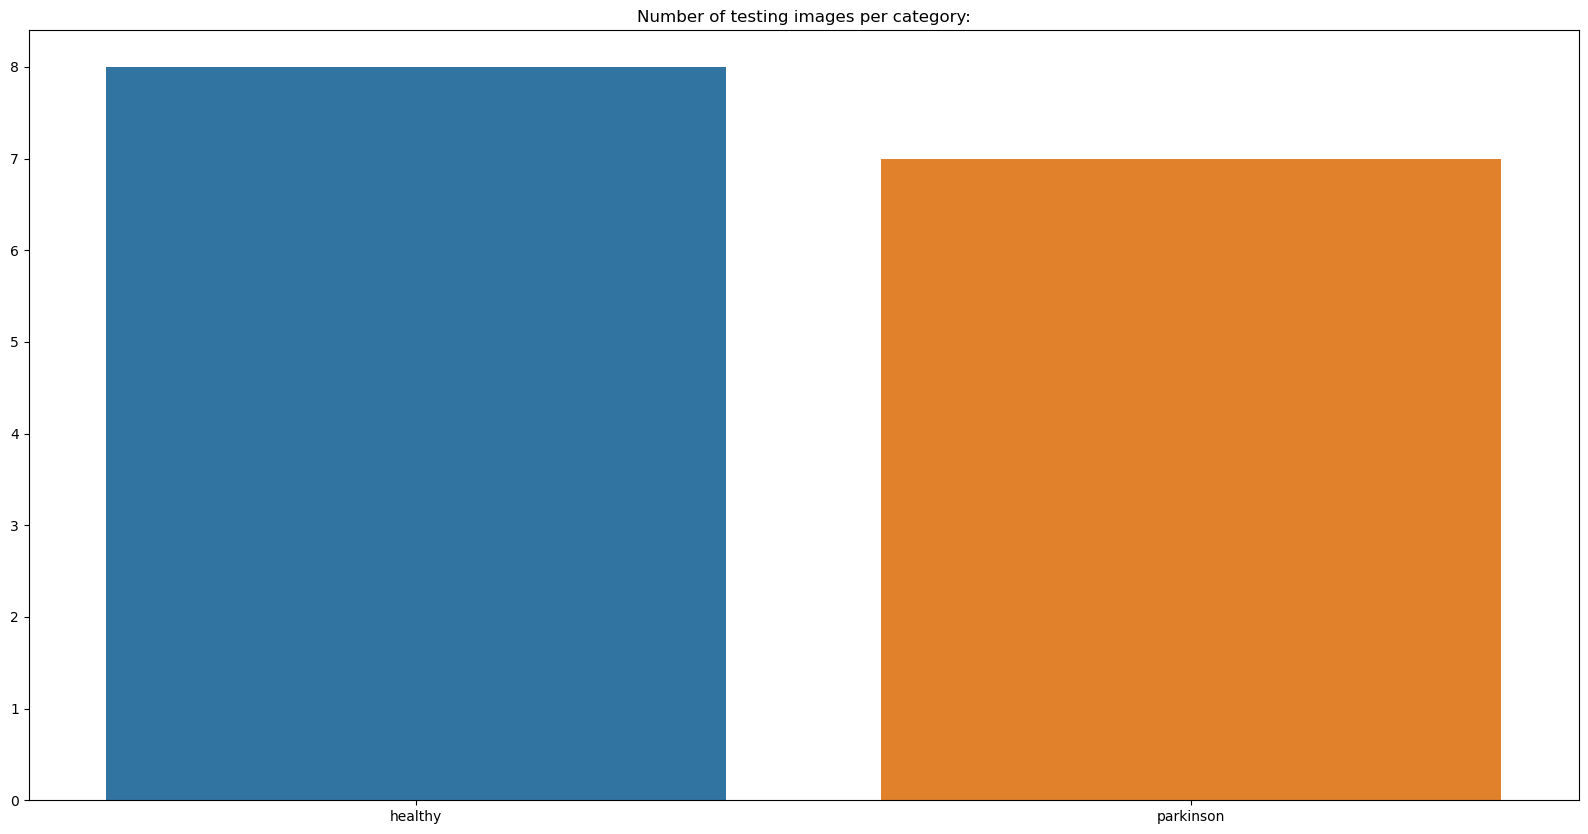

In [7]:
unique_test, count_test = np.unique(y_test, return_counts=True)
plt.figure(figsize=(20, 10))
sns.barplot(x=unique_test, y=count_test).set_title("Number of testing images per category:")
plt.show()

In [8]:
# Augmenting the Dataset
train_data_generator = ImageDataGenerator(rotation_range=360, horizontal_flip=True, vertical_flip=True)

x_aug_train = []
y_aug_train = []

for (i, v) in enumerate(y_train):
    x_img = x_train[i]
    x_img = np.expand_dims(x_img, axis=0)
    aug_iter = train_data_generator.flow(x_img, batch_size=1, shuffle=True)
    for j in range(70):
        aug_image = next(aug_iter)[0].astype('uint8')
        x_aug_train.append(aug_image)
        y_aug_train.append(v)

x_train = np.concatenate((x_train, np.array(x_aug_train)), axis=0)
y_train = np.concatenate((y_train, np.array(y_aug_train)), axis=0)

print(f"x_train shape after augmentation: {x_train.shape}")
print(f"y_train shape after augmentation: {y_train.shape}")

x_train shape after augmentation: (4047, 128, 128, 3)
y_train shape after augmentation: (4047,)


In [9]:
# Preprocessing the Images
x_train = np.array([cv2.cvtColor(cv2.resize(img, (128, 128)), cv2.COLOR_BGR2GRAY) for img in x_train])
x_test = np.array([cv2.cvtColor(cv2.resize(img, (128, 128)), cv2.COLOR_BGR2GRAY) for img in x_test])

x_train = x_train / 255.0
x_test = x_test / 255.0

label_encoder = LabelEncoder()
y_train = to_categorical(label_encoder.fit_transform(y_train))
y_test = to_categorical(label_encoder.transform(y_test))

x_train = np.expand_dims(x_train, axis=-1)
x_test = np.expand_dims(x_test, axis=-1)

print(f"x_train shape after preprocessing: {x_train.shape}")
print(f"y_train shape after preprocessing: {y_train.shape}")
print(f"x_test shape after preprocessing: {x_test.shape}")
print(f"y_test shape after preprocessing: {y_test.shape}")


x_train shape after preprocessing: (4047, 128, 128, 1)
y_train shape after preprocessing: (4047, 2)
x_test shape after preprocessing: (15, 128, 128, 1)
y_test shape after preprocessing: (15, 2)


In [10]:
# Define the Model
def parkinson_disease_detection_model(input_shape=(128, 128, 1)):
    regularizer = tf.keras.regularizers.l2(0.001)
    model = Sequential()
    model.add(Input(shape=input_shape))
    model.add(Conv2D(128, (5, 5), padding='same', strides=(1, 1), name='conv1', activation='relu', kernel_initializer='glorot_uniform', kernel_regularizer=regularizer))
    model.add(MaxPool2D((9, 9), strides=(3, 3)))
    model.add(Conv2D(64, (5, 5), padding='same', strides=(1, 1), name='conv2', activation='relu', kernel_initializer='glorot_uniform', kernel_regularizer=regularizer))
    model.add(MaxPool2D((7, 7), strides=(3, 3)))
    model.add(Conv2D(32, (3, 3), padding='same', strides=(1, 1), name='conv3', activation='relu', kernel_initializer='glorot_uniform', kernel_regularizer=regularizer))
    model.add(MaxPool2D((5, 5), strides=(2, 2)))
    model.add(Conv2D(32, (3, 3), padding='same', strides=(1, 1), name='conv4', activation='relu', kernel_initializer='glorot_uniform', kernel_regularizer=regularizer))
    model.add(MaxPool2D((3, 3), strides=(2, 2)))
    model.add(Flatten())
    model.add(Dropout(0.5))
    model.add(Dense(64, activation='relu', kernel_initializer='glorot_uniform', name='fc1'))
    model.add(Dropout(0.5))
    model.add(Dense(2, activation='softmax', kernel_initializer='glorot_uniform', name='fc3'))
    optimizer = Adam(3.15e-5)
    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
    return model

model = parkinson_disease_detection_model(input_shape=(128, 128, 1))
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv1 (Conv2D)                       │ (None, 128, 128, 128)       │           3,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 40, 40, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2 (Conv2D)                       │ (None, 40, 40, 64)          │         204,864 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 12, 12, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv3 (Conv2D)                       │ (None, 12, 12, 32)          │          18,464 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 4, 4, 32)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv4 (Conv2D)                       │ (None, 4, 4, 32)            │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 1, 1, 32)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ fc1 (Dense)                          │ (None, 64)                  │           2,112 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ fc3 (Dense)                          │ (None, 2)                   │             130 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 238,146 (930.26 KB)

 Trainable params: 238,146 (930.26 KB)

 Non-trainable params: 0 (0.00 B)

In [11]:
# Training the Model
hist = model.fit(x_train, y_train, batch_size=128, epochs=70, validation_data=(x_test, y_test))

Epoch 1/70
32/32 ━━━━━━━━━━━━━━━━━━━━ 29s 826ms/step - accuracy: 0.5095 - loss: 0.8546 - val_accuracy: 0.4667 - val_loss: 0.8494
Epoch 2/70
32/32 ━━━━━━━━━━━━━━━━━━━━ 24s 757ms/step - accuracy: 0.4915 - loss: 0.8477 - val_accuracy: 0.4667 - val_loss: 0.8435
Epoch 3/70
32/32 ━━━━━━━━━━━━━━━━━━━━ 23s 733ms/step - accuracy: 0.5064 - loss: 0.8422 - val_accuracy: 0.4667 - val_loss: 0.8374
Epoch 4/70
32/32 ━━━━━━━━━━━━━━━━━━━━ 26s 806ms/step - accuracy: 0.5355 - loss: 0.8351 - val_accuracy: 0.4667 - val_loss: 0.8326
Epoch 5/70
32/32 ━━━━━━━━━━━━━━━━━━━━ 38s 1s/step - accuracy: 0.5262 - loss: 0.8301 - val_accuracy: 0.4667 - val_loss: 0.8272
Epoch 6/70
32/32 ━━━━━━━━━━━━━━━━━━━━ 45s 1s/step - accuracy: 0.5337 - loss: 0.8246 - val_accuracy: 0.4667 - val_loss: 0.8234
Epoch 7/70
32/32 ━━━━━━━━━━━━━━━━━━━━ 44s 1s/step - accuracy: 0.5493 - loss: 0.8180 - val_accuracy: 0.4667 - val_loss: 0.8201
Epoch 8/70
32/32 ━━━━━━━━━━━━━━━━━━━━ 40s 1s/step - accuracy: 0.5405 - loss: 0.8150 - val_accuracy: 0.4667

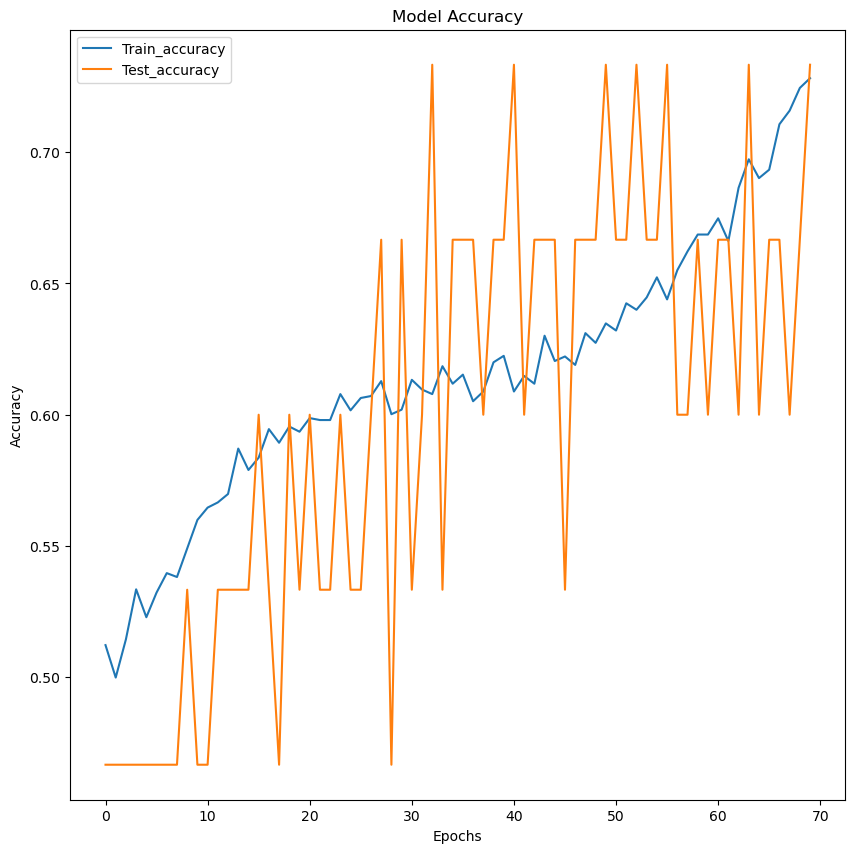

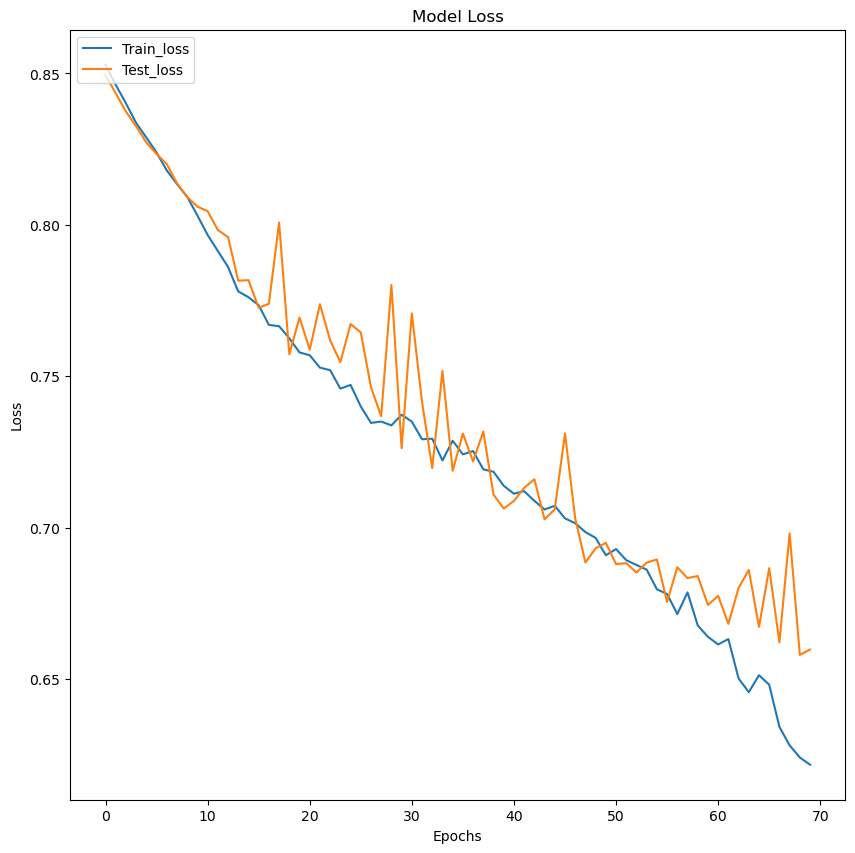

In [12]:
figure = plt.figure(figsize=(10, 10))
plt.plot(hist.history['accuracy'], label='Train_accuracy')
plt.plot(hist.history['val_accuracy'], label='Test_accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc="upper left")
plt.show()

figure2 = plt.figure(figsize=(10, 10))
plt.plot(hist.history['loss'], label='Train_loss')
plt.plot(hist.history['val_loss'], label='Test_loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(loc="upper left")
plt.show()

In [23]:
import pandas as pd
from sklearn.metrics import confusion_matrix, classification_report

In [24]:
ypred = model.predict(x_test)
ypred = np.argmax(ypred, axis=1)
y_test_pred = np.argmax(y_test, axis=1)
print(classification_report(y_test_pred, ypred))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
              precision    recall  f1-score   support

           0       0.70      0.88      0.78         8
           1       0.80      0.57      0.67         7

    accuracy                           0.73        15
   macro avg       0.75      0.72      0.72        15
weighted avg       0.75      0.73      0.73        15



<Axes: >

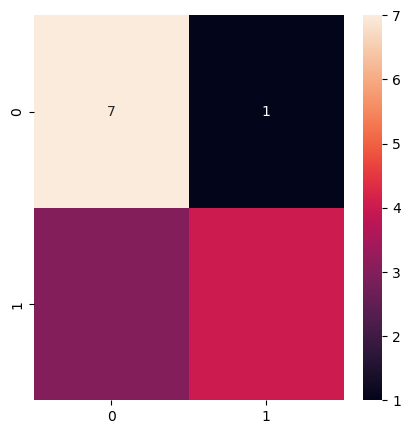

In [25]:
matrix = confusion_matrix(y_test_pred, ypred)
df_cm = pd.DataFrame(matrix, index=[0, 1], columns=[0, 1])
figure = plt.figure(figsize=(5, 5))
sns.heatmap(df_cm, annot=True, fmt='d')

In [27]:
model.save('parkinson_disease_detection.h5')

In [28]:
labels = ['Healthy', 'Parkinson']
image_healthy = cv2.imread(r'C:\Users\anagh\Downloads\DD\wave\wave\testing\healthy\V08HO01.png')
image_parkinson = cv2.imread(r'C:\Users\anagh\Downloads\DD\wave\wave\testing\parkinson\V01PO01.png')

image_healthy = cv2.resize(image_healthy, (128, 128))
image_healthy = cv2.cvtColor(image_healthy, cv2.COLOR_BGR2GRAY)
image_healthy = np.array(image_healthy)
image_healthy = np.expand_dims(image_healthy, axis=0)
image_healthy = np.expand_dims(image_healthy, axis=-1)

image_parkinson = cv2.resize(image_parkinson, (128, 128))
image_parkinson = cv2.cvtColor(image_parkinson, cv2.COLOR_BGR2GRAY)
image_parkinson = np.array(image_parkinson)
image_parkinson = np.expand_dims(image_parkinson, axis=0)
image_parkinson = np.expand_dims(image_parkinson, axis=-1)

In [29]:
ypred_healthy = model.predict(image_healthy)
ypred_parkinson = model.predict(image_parkinson)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


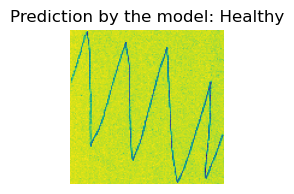

In [30]:
figure = plt.figure(figsize=(2, 2))
img_healthy = np.squeeze(image_healthy, axis=0)
plt.imshow(img_healthy)
plt.axis('off')
plt.title(f'Prediction by the model: {labels[np.argmax(ypred_healthy[0], axis=0)]}')
plt.show()

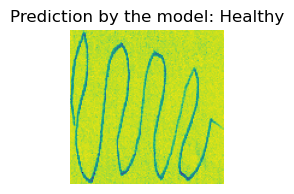

In [31]:
figure = plt.figure(figsize=(2, 2))
image_parkinson = np.squeeze(image_parkinson, axis=0)
plt.imshow(image_parkinson)
plt.axis('off')
plt.title(f'Prediction by the model: {labels[np.argmax(ypred_parkinson[0], axis=0)]}')
plt.show()